In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter, medfilt

# Constants

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

# Filter 

In [3]:
class LowPassFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=1500, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y

# Functions

In [4]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def get_processed_grf(grf, clip=False):
    singn_corrected = grf if np.mean(grf) > 0 else (-grf)
    processed_grf = LowPassFilter.apply(singn_corrected, fs=1500, cutoff=20)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 3, axis=0).T

def get_processed_moment(moment):
    processed_moment = LowPassFilter.apply(moment, fs=1500, cutoff=20)
    return resample(processed_moment, N_SAMPLES * 3, axis=0).T

def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 9:15, :]
        trajectory_y = content['data']['points'][1, 9:15, :]
        trajectory_z = content['data']['points'][2, 9:15, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 20:26, :]
        trajectory_y = content['data']['points'][1, 20:26, :]
        trajectory_z = content['data']['points'][2, 20:26, :]

    else:
        raise ValueError('Third foot is not allowed')

    # trajectory_x = LowPassFilter.apply(trajectory_x, fs=200, cutoff=20)
    # trajectory_y = LowPassFilter.apply(trajectory_y, fs=200, cutoff=20)
    # trajectory_z = LowPassFilter.apply(trajectory_z, fs=200, cutoff=20)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 3, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 3, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 3, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force(content):
    force_x = []
    force_y = []
    force_z = []
    for i in range(2):
        force_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_x, force_y, force_z

def get_moment(content):
    moment_x = []
    moment_y = []
    moment_z = []
    for i in range(2):
        moment_x.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][0, :]
            )
        )
        moment_y.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][1, :]
            )
        )
        moment_z.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][2, :]
            )
        )

    return moment_x, moment_y, moment_z

# Test Bench

In [5]:
path = '/home/ai/Python/GRF-Synthesis-from-Motion-Trajectories/Dataset/gait-dbase-1/2014001/2014001_C1_04.c3d'
content = c3d(path, extract_forceplat_data=True)

In [6]:
trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

force_x, force_y, force_z = get_force(content)

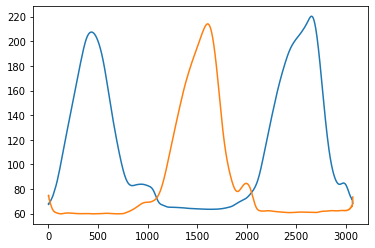

In [7]:
plt.plot(trajectory_z_l[:, 0])
plt.plot(trajectory_z_r[:, 0])
plt.show()

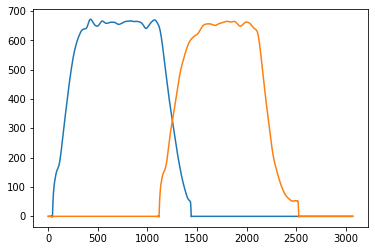

In [8]:
plt.plot(force_z[0])
plt.plot(force_z[1])
plt.show()

In [9]:
mask_force_z_1 = (force_z[0] > FORCE_THRESHOLD)
mask_force_z_2 = (force_z[1] > FORCE_THRESHOLD)

start_1 = np.min(np.argwhere(mask_force_z_1 == True))
end_1 = np.max(np.argwhere(mask_force_z_1 == True))

start_2 = np.min(np.argwhere(mask_force_z_2 == True))
end_2 = np.max(np.argwhere(mask_force_z_2 == True))

force_x_1 = force_x[0][start_1 : end_1]
force_y_1 = force_y[0][start_1 : end_1]
force_z_1 = force_z[0][start_1 : end_1]

force_x_2 = force_x[1][start_2 : end_2]
force_y_2 = force_y[1][start_2 : end_2]
force_z_2 = force_z[1][start_2 : end_2]

temp_l = trajectory_z_l[start_1 : end_1, 0]
temp_r = trajectory_z_r[start_1 : end_1, 0]

force_x_r = 0
force_y_r = 0
force_z_r = 0

force_x_l = 0
force_y_l = 0
force_z_l = 0

if np.sum(temp_l) > np.sum(temp_r):
    force_x_r = force_x_1
    force_y_r = force_y_1
    force_z_r = force_z_1

    force_x_l = force_x_2
    force_y_l = force_y_2
    force_z_l = force_z_2

    trajectory_x_r = trajectory_x_l[start_2 : end_2]
    trajectory_y_r = trajectory_y_r[start_2 : end_2]
    trajectory_z_r = trajectory_z_r[start_2 : end_2]

    trajectory_x_l = trajectory_x_r[start_1 : end_1]
    trajectory_y_l = trajectory_y_l[start_1 : end_1]
    trajectory_z_l = trajectory_z_l[start_1 : end_1]

else:
    force_x_l = force_x_1
    force_y_l = force_y_1
    force_z_l = force_z_1

    force_x_r = force_x_2
    force_y_r = force_y_2
    force_z_r = force_z_2

    trajectory_x_r = trajectory_x_l[start_1 : end_1]
    trajectory_y_r = trajectory_y_r[start_1 : end_1]
    trajectory_z_r = trajectory_z_r[start_1 : end_1]

    trajectory_x_l = trajectory_x_r[start_2 : end_2]
    trajectory_y_l = trajectory_y_l[start_2 : end_2]
    trajectory_z_l = trajectory_z_l[start_2 : end_2]

# ... Resample
trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

# ... Standardize
trajectory_x_r = standardize(trajectory_x_r)
trajectory_y_r = standardize(trajectory_y_r)
trajectory_z_r = standardize(trajectory_z_r)

trajectory_x_l = standardize(trajectory_x_l)
trajectory_y_l = standardize(trajectory_y_l)
trajectory_z_l = standardize(trajectory_z_l)

force_x_r = standardize(force_x_r)
force_y_r = standardize(force_y_r)
force_z_r = standardize(force_z_r)

force_x_l = standardize(force_x_l)
force_y_l = standardize(force_y_l)
force_z_l = standardize(force_z_l)

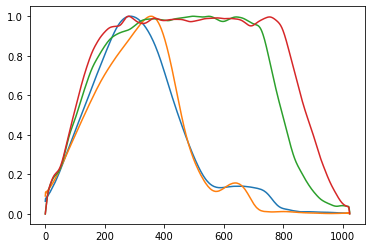

In [10]:
plt.plot(trajectory_z_l[:, 0])
plt.plot(trajectory_z_r[:, 0])
plt.plot(force_z_l)
plt.plot(force_z_r)

# Extract Features

In [6]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in subjects:
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        if 'ST' in filename:
            continue

        print(subject, filename)

        try:
            content = c3d(os.path.join(path, subject, filename), extract_forceplat_data=True)
            
            trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
            trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

            force_x, force_y, force_z = get_force(content)
            
            force_combined_z = force_z[0] + force_z[1]
            force_mask = (force_combined_z >= FORCE_THRESHOLD)

            # ... Remove all zero GRF samples
            if np.sum(force_z[0]) <= FORCE_THRESHOLD or np.sum(force_z[1]) <= FORCE_THRESHOLD:
                # print(os.path.join(path, subject, filename))
                n_bad_samples = n_bad_samples + 1
                continue

            # ... Remove bad samples
            if np.mean(force_mask) <= 0.5:
                # print(os.path.join(path, subject, filename))
                n_bad_samples = n_bad_samples + 1
                continue

            # ... Remove samples that starts and ends abruptly
            if np.mean(force_combined_z[:10]) >= 200 or np.mean(force_combined_z[-10:]) >= 200:
                # print(os.path.join(path, subject, filename))
                n_bad_samples = n_bad_samples + 1
                continue

            mask_force_z_1 = (force_z[0] > FORCE_THRESHOLD)
            mask_force_z_2 = (force_z[1] > FORCE_THRESHOLD)

            start_1 = np.min(np.argwhere(mask_force_z_1 == True))
            end_1 = np.max(np.argwhere(mask_force_z_1 == True))

            if (end_1 - start_1) < 100:
                n_bad_samples = n_bad_samples + 1
                continue

            start_2 = np.min(np.argwhere(mask_force_z_2 == True))
            end_2 = np.max(np.argwhere(mask_force_z_2 == True))

            if (end_2 - start_2) < 100:
                n_bad_samples = n_bad_samples + 1
                continue

            force_x_1 = force_x[0][start_1 : end_1]
            force_y_1 = force_y[0][start_1 : end_1]
            force_z_1 = force_z[0][start_1 : end_1]

            force_x_2 = force_x[1][start_2 : end_2]
            force_y_2 = force_y[1][start_2 : end_2]
            force_z_2 = force_z[1][start_2 : end_2]

            temp_l = trajectory_z_l[start_1 : end_1, 0]
            temp_r = trajectory_z_r[start_1 : end_1, 0]

            force_x_r = 0
            force_y_r = 0
            force_z_r = 0

            force_x_l = 0
            force_y_l = 0
            force_z_l = 0

            if np.sum(temp_l) > np.sum(temp_r):
                force_x_r = force_x_1
                force_y_r = force_y_1
                force_z_r = force_z_1

                force_x_l = force_x_2
                force_y_l = force_y_2
                force_z_l = force_z_2

                trajectory_x_r = trajectory_x_l[start_2 : end_2]
                trajectory_y_r = trajectory_y_r[start_2 : end_2]
                trajectory_z_r = trajectory_z_r[start_2 : end_2]

                trajectory_x_l = trajectory_x_r[start_1 : end_1]
                trajectory_y_l = trajectory_y_l[start_1 : end_1]
                trajectory_z_l = trajectory_z_l[start_1 : end_1]

            else:
                force_x_l = force_x_1
                force_y_l = force_y_1
                force_z_l = force_z_1

                force_x_r = force_x_2
                force_y_r = force_y_2
                force_z_r = force_z_2

                trajectory_x_r = trajectory_x_l[start_1 : end_1]
                trajectory_y_r = trajectory_y_r[start_1 : end_1]
                trajectory_z_r = trajectory_z_r[start_1 : end_1]

                trajectory_x_l = trajectory_x_r[start_2 : end_2]
                trajectory_y_l = trajectory_y_l[start_2 : end_2]
                trajectory_z_l = trajectory_z_l[start_2 : end_2]

            # ... Resample
            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

            force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
            force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
            force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

            force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
            force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
            force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

            # ... Standardize
            trajectory_x_r = standardize(trajectory_x_r)
            trajectory_y_r = standardize(trajectory_y_r)
            trajectory_z_r = standardize(trajectory_z_r)

            trajectory_x_l = standardize(trajectory_x_l)
            trajectory_y_l = standardize(trajectory_y_l)
            trajectory_z_l = standardize(trajectory_z_l)

            force_x_r = standardize(force_x_r)
            force_y_r = standardize(force_y_r)
            force_z_r = standardize(force_z_r)

            force_x_l = standardize(force_x_l)
            force_y_l = standardize(force_y_l)
            force_z_l = standardize(force_z_l)


                    
            _features_l = pd.DataFrame(
                np.concatenate([trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features_r = pd.DataFrame(
                np.concatenate([trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features = pd.concat([_features_l, _features_r], axis=0)

            _target_r = pd.DataFrame(
                np.stack([force_x_r, force_y_r, force_z_r], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target_l = pd.DataFrame(
                np.stack([force_x_l, force_y_l, force_z_l], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target = pd.concat([_target_r, _target_l], axis=0)

            features = pd.concat([features, _features], axis=0, ignore_index=True)
            target = pd.concat([target, _target], axis=0, ignore_index=True)

            records.append(filename)

            n_samples = n_samples + 1

        except Exception as e:
            # print(f'ERROR [{subject}/{filename}]: {e}')
            n_bad_samples = n_bad_samples + 1
            pass

print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)


2015032 2015032_C4_02.c3d
2015032 2015032_C4_01.c3d
2015032 2015032_C2_03.c3d
2015032 2015032_C5_01.c3d
2015032 2015032_C1_05.c3d
2015032 2015032_C2_01.c3d
2015032 2015032_C1_01.c3d
2015032 2015032_C2_02.c3d
2015032 2015032_C2_04.c3d
2015032 2015032_C3_02.c3d
2015032 2015032_C3_01.c3d
2015032 2015032_C5_02.c3d
2015032 2015032_C1_02.c3d
2015032 2015032_C5_03.c3d
2015032 2015032_C4_03.c3d
2015032 2015032_C5_04.c3d
2015032 2015032_C1_04.c3d
2015032 2015032_C3_04.c3d
2015032 2015032_C5_05.c3d
2015032 2015032_C1_03.c3d
2015032 2015032_C3_03.c3d
2014049 2014049_C5_04.c3d
2014049 2014049_C1_04.c3d
2014049 2014049_C4_03.c3d
2014049 2014049_C2_03.c3d
2014049 2014049_C1_02.c3d
2014049 2014049_C4_04.c3d
2014049 2014049_C5_01.c3d
2014049 2014049_C2_04.c3d
2014049 2014049_C1_01.c3d
2014049 2014049_C5_05.c3d
2014049 2014049_C2_05.c3d
2014049 2014049_C1_05.c3d
2014049 2014049_C5_02.c3d
2014049 2014049_C2_01.c3d
2014049 2014049_C5_03.c3d
2014049 2014049_C3_01.c3d
2014049 2014049_C3_03.c3d
2014049 2014

In [ ]:
features

In [ ]:
target

# Verification

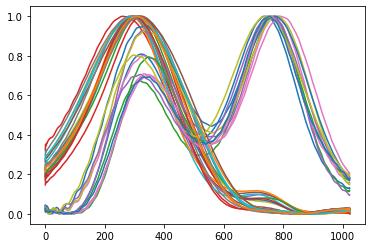

In [71]:
x = features['fal_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

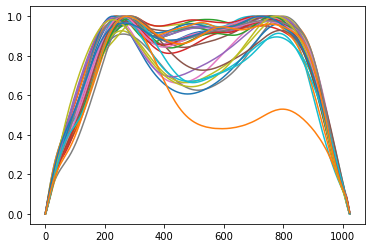

In [72]:
y = target['fz'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

In [ ]:
path = '../../Dataset/Processed/data.joblib'
data = {
    'X': features,
    'y': target
}
# dump(data, path)

In [ ]:
content = c3d('../../Dataset/gait-dbase-1/2015030/2015030_C5_02.c3d', extract_forceplat_data=True)
force_z_1 = content['data']['platform'][0]['force'][2, :]
force_z_2 = content['data']['platform'][1]['force'][2, :]
trajectory_z_l = content['data']['points'][2, 9:15, :]
trajectory_z_r = content['data']['points'][2, 20:26, :]

plt.plot(trajectory_z_l.T)
plt.plot(trajectory_z_r.T)

# plt.legend(['Left', 'Right'])

In [ ]:
data_n = load(path)
X = data_n['X']
y = data_n['y']

fz = y['fz'].to_numpy().reshape(-1, N_SAMPLES)

In [ ]:
plt.plot(fz.T)

In [ ]:
fz